# **Chapter 10. Working with Data**

## Exploring Your Data

In [ ]:
import requests
# Save datagenerators as file to colab working directory
# If you are using GitHub, make sure you get the "Raw" version of the code
url = 'https://raw.githubusercontent.com/joelgrus/data-science-from-scratch/master/scratch/probability.py'
r = requests.get(url)

# make sure your filename is the same as how you want to import 
with open('probability.py', 'w') as f:
    f.write(r.text)

# now we can import
from probability import inverse_normal_cdf

url = 'https://raw.githubusercontent.com/joelgrus/data-science-from-scratch/master/scratch/linear_algebra.py'
r = requests.get(url)

with open('linear_algebra.py', 'w') as f:
    f.write(r.text)

from linear_algebra import Matrix, Vector, make_matrix, distance, vector_mean, dot, subtract, magnitude, distance, add, scalar_multiply

def gradient_step(v: Vector, gradient: Vector, step_size: float) -> Vector:
    """Moves `step_size` in the `gradient` direction from `v`"""
    assert len(v) == len(gradient)
    step = scalar_multiply(step_size, gradient)
    return add(v, step)

<Figure size 432x288 with 0 Axes>

### Exploring One-Dimensional Data

* A good next step is to create a histogram, in which you group your data into discrete buckets and count how many points fall into each bucket:

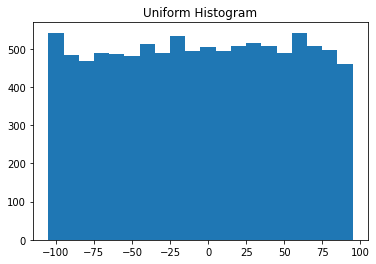

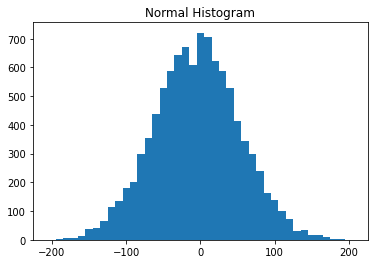

In [ ]:
from typing import List, Dict
from collections import Counter
import math

import matplotlib.pyplot as plt

def bucketize(point: float, bucket_size: float) -> float:
    """Floor the point to the next lower multiple of bucket_size"""
    return bucket_size * math.floor(point / bucket_size)

def make_histogram(points: List[float], bucket_size: float) -> Dict[float, int]:
    """Buckets the points and counts how many in each bucket"""
    return Counter(bucketize(point, bucket_size) for point in points)

def plot_histogram(points: List[float], bucket_size: float, title: str = ""):
    histogram = make_histogram(points, bucket_size)
    plt.bar(histogram.keys(), histogram.values(), width=bucket_size)
    plt.title(title)

import random

random.seed(0)

# uniform between -100 and 100
uniform = [200 * random.random() - 100 for _ in range(10000)]

# normal distribution with mean 0, standard deviation 57
normal = [57 * inverse_normal_cdf(random.random())
          for _ in range(10000)]

plot_histogram(uniform, 10, "Uniform Histogram")
plt.show()

plot_histogram(normal, 10, "Normal Histogram")
plt.show()

### Two Dimensions

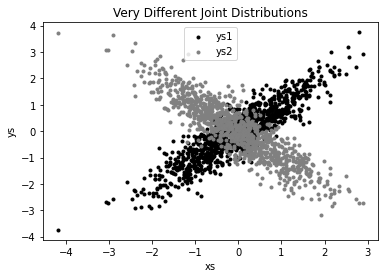

In [ ]:
import random

def random_normal() -> float:
    """Returns a random draw from a standard normal distribution"""
    return inverse_normal_cdf(random.random())

xs = [random_normal() for _ in range(1000)]
ys1 = [ x + random_normal() / 2 for x in xs]
ys2 = [-x + random_normal() / 2 for x in xs]

plt.scatter(xs, ys1, marker='.', color='black', label='ys1')
plt.scatter(xs, ys2, marker='.', color='gray',  label='ys2')
plt.xlabel('xs')
plt.ylabel('ys')
plt.legend(loc=9)
plt.title("Very Different Joint Distributions")
plt.show()

### Many Dimensions

* A simple approach is to look at the **correlation matrix**, in which the entry in row *i* and column *j* is the correlation between the *i*-th dimension and the *j*-th dimension of the data:

![picture](https://drive.google.com/uc?id=1mgKjjGwbDtu3dw6IOpfrn8Toysy6ooyI)

In [ ]:
import scipy
from scipy.stats.stats import pearsonr

def correlation(xs: List[float], ys: List[float]) -> float:
    r, p = scipy.stats.pearsonr(xs, ys)
    return r

assert 0.89 < correlation(xs, ys1) < 0.91
assert -0.91 < correlation(xs, ys2) < -0.88

print(correlation(xs, ys1)) # about 0.9
print(correlation(xs, ys2)) # about -0.9

def correlation_matrix(data: List[Vector]) -> Matrix:
    """
    Returns the len(data) x len(data) matrix whose (i, j)-th entry
    is the correlation between data[i] and data[j]
    """
    def correlation_ij(i: int, j: int) -> float:
        return correlation(data[i], data[j])

    return make_matrix(len(data), len(data), correlation_ij)

vectors = [xs, ys1, ys2]
assert correlation_matrix(vectors) == [
    [correlation(xs,  xs), correlation(xs,  ys1), correlation(xs,  ys2)],
    [correlation(ys1, xs), correlation(ys1, ys1), correlation(ys1, ys2)],
    [correlation(ys2, xs), correlation(ys2, ys1), correlation(ys2, ys2)],
]

0.9010493686379649
-0.8920981526879995


* A more visual approach (if you don't have too many dimensions) is to make a **scatterplot matrix**  showing all the pairwise scatterplots.

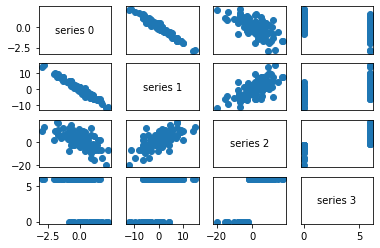

In [ ]:
from typing import List

# Just some random data to show off correlation scatterplots
num_points = 100

def random_row() -> List[float]:
   row = [0.0, 0, 0, 0]
   row[0] = random_normal()
   row[1] = -5 * row[0] + random_normal()
   row[2] = row[0] + row[1] + 5 * random_normal()
   row[3] = 6 if row[2] > -2 else 0
   return row

random.seed(0)
# each row has 4 points, but really we want the columns
corr_rows = [random_row() for _ in range(num_points)]
corr_data = [list(col) for col in zip(*corr_rows)]

# corr_data is a list of four 100-d vectors
num_vectors = len(corr_data)
fig, ax = plt.subplots(num_vectors, num_vectors)

for i in range(num_vectors):
    for j in range(num_vectors):

        # Scatter column_j on the x-axis vs column_i on the y-axis,
        if i != j: ax[i][j].scatter(corr_data[j], corr_data[i])

        # unless i == j, in which case show the series name.
        else: ax[i][j].annotate("series " + str(i), (0.5, 0.5),
                                xycoords='axes fraction',
                                ha="center", va="center")

        # Then hide axis labels except left and bottom charts
        if i < num_vectors - 1: ax[i][j].xaxis.set_visible(False)
        if j > 0: ax[i][j].yaxis.set_visible(False)

# Fix the bottom right and top left axis labels, which are wrong because
# their charts only have text in them
ax[-1][-1].set_xlim(ax[0][-1].get_xlim())
ax[0][0].set_ylim(ax[0][1].get_ylim())

plt.show()

## Using NamedTuples

In [ ]:
import datetime

stock_price = {'closing_price': 102.06,
               'date': datetime.date(2014, 8, 29),
               'symbol': 'AAPL'}

# oops, typo
stock_price['cosing_price'] = 103.06

prices: Dict[datetime.date, float] = {}

* We do type annotation using the typed varaint, `NamedTuple`:

In [ ]:
from typing import NamedTuple

class StockPrice(NamedTuple):
    symbol: str
    date: datetime.date
    closing_price: float

    def is_high_tech(self) -> bool:
        """It's a class, so we can add methods too"""
        return self.symbol in ['MSFT', 'GOOG', 'FB', 'AMZN', 'AAPL']

price = StockPrice('MSFT', datetime.date(2018, 12, 14), 106.03)

assert price.symbol == 'MSFT'
assert price.closing_price == 106.03
assert price.is_high_tech()

## Cleaning and Munging

* Real-world data is dirty.

In [ ]:
from dateutil.parser import parse

def parse_row(row: List[str]) -> StockPrice:
    symbol, date, closing_price = row
    return StockPrice(symbol=symbol,
                      date=parse(date).date(),
                      closing_price=float(closing_price))

# Now test our function
stock = parse_row(["MSFT", "2018-12-14", "106.03"])

assert stock.symbol == "MSFT"
assert stock.date == datetime.date(2018, 12, 14)
assert stock.closing_price == 106.03

* What if there's bad data? Maybe you'd rather get a None than crash your program?

In [ ]:
from typing import Optional
import re

def try_parse_row(row: List[str]) -> Optional[StockPrice]:
    symbol, date_, closing_price_ = row

    # Stock symbol should be all capital letters
    if not re.match(r"^[A-Z]+$", symbol):
        return None

    try:
        date = parse(date_).date()
    except ValueError:
        return None

    try:
        closing_price = float(closing_price_)
    except ValueError:
        return None

    return StockPrice(symbol, date, closing_price)

# Should return None for errors
assert try_parse_row(["MSFT0", "2018-12-14", "106.03"]) is None
assert try_parse_row(["MSFT", "2018-12--14", "106.03"]) is None
assert try_parse_row(["MSFT", "2018-12-14", "x"]) is None

# But should return same as before if data is good.
assert try_parse_row(["MSFT", "2018-12-14", "106.03"]) == stock

In [ ]:
url = 'https://raw.githubusercontent.com/joelgrus/data-science-from-scratch/master/comma_delimited_stock_prices.csv'
r = requests.get(url)

with open('comma_delimited_stock_prices.csv', 'w') as f:
    f.write(r.text)

import csv

data: List[StockPrice] = []

with open("comma_delimited_stock_prices.csv") as f:
    reader = csv.reader(f)
    for row in reader:
        maybe_stock = try_parse_row(row)
        if maybe_stock is None:
            print(f"skipping invalid row: {row}")
        else:
            data.append(maybe_stock)

skipping invalid row: ['MSFT', '6/19/2014', 'n/a']


## Manipulating Data

* One of the most important skills of a data scientist is manipulating data.

* For instance, suppose we want to know the highest-ever closing price for AAPL. Let's break this down into concrete steps:
>1. Restrict ourselves to AAPL rows.
>2. Grab the closing_price from each row.
>3. Take the max of those prices.
* We can do all three at once using a comprehension:

In [ ]:
url = 'https://raw.githubusercontent.com/joelgrus/data-science-from-scratch/master/stocks.csv'
r = requests.get(url)

with open('stocks.csv', 'w') as f:
    f.write(r.text)

from dateutil.parser import parse
import csv

with open("stocks.csv", "r") as f:
    reader = csv.DictReader(f)
    rows = [[row['Symbol'], row['Date'], row['Close']]
            for row in reader]

# skip header
maybe_data = [try_parse_row(row) for row in rows]

# Make sure they all loaded successfully:
assert maybe_data
assert all(sp is not None for sp in maybe_data)

# This is just to make mypy happy
data = [sp for sp in maybe_data if sp is not None]

max_aapl_price = max(stock_price.closing_price
                     for stock_price in data
                     if stock_price.symbol == "AAPL")

In [ ]:
from collections import defaultdict

max_prices: Dict[str, float] = defaultdict(lambda: float('-inf'))

for sp in data:
    symbol, closing_price = sp.symbol, sp.closing_price
    if closing_price > max_prices[symbol]:
        max_prices[symbol] = closing_price

* We can now start to ask more complicated things, like what are the largest and smallest one-day percent changes in our dataset. The percent change is *price_today* / *price_yesterday - 1*, which means we need some way of associating today’s price and yesterday’s price. One approach is to group the prices by symbol, and then, within each group:
>1. Order the prices by date.
>2. Use zip to get (previous, current) pairs.
>3. Turn the pairs into new "percent change" rows.

* Let's start by grouping the prices by symbol:

In [ ]:
from typing import List
from collections import defaultdict

# Collect the prices by symbol
prices: Dict[str, List[StockPrice]] = defaultdict(list)

for sp in data:
    prices[sp.symbol].append(sp)

* Since the prices are tuples, they'll get sorted by their fields in order: first by symbol, then by date, then by price. This means that if we have some prices all with the same symbol, sort will sort them by date (and then by price, which does nothing, since we only have one per date), which is what we want.

In [ ]:
# Order the prices by date
prices = {symbol: sorted(symbol_prices)
          for symbol, symbol_prices in prices.items()}

def pct_change(yesterday: StockPrice, today: StockPrice) -> float:
    return today.closing_price / yesterday.closing_price - 1

class DailyChange(NamedTuple):
    symbol: str
    date: datetime.date
    pct_change: float

def day_over_day_changes(prices: List[StockPrice]) -> List[DailyChange]:
    """
    Assumes prices are for one stock and are in order
    """
    return [DailyChange(symbol=today.symbol,
                        date=today.date,
                        pct_change=pct_change(yesterday, today))
            for yesterday, today in zip(prices, prices[1:])]

all_changes = [change
               for symbol_prices in prices.values()
               for change in day_over_day_changes(symbol_prices)]

max_change = max(all_changes, key=lambda change: change.pct_change)
# see, e.g. http://news.cnet.com/2100-1001-202143.html
assert max_change.symbol == 'AAPL'
assert max_change.date == datetime.date(1997, 8, 6)
assert 0.33 < max_change.pct_change < 0.34

min_change = min(all_changes, key=lambda change: change.pct_change)
# see, e.g. http://money.cnn.com/2000/09/29/markets/techwrap/
assert min_change.symbol == 'AAPL'
assert min_change.date == datetime.date(2000, 9, 29)
assert -0.52 < min_change.pct_change < -0.51

* We can now use this new `all_changes` dataset to find which month is the best to invest in tech stocks. We'll just look at the average daily change by month:

In [ ]:
changes_by_month: List[DailyChange] = {month: [] for month in range(1, 13)}

for change in all_changes:
    changes_by_month[change.date.month].append(change)

avg_daily_change = {
    month: sum(change.pct_change for change in changes) / len(changes)
    for month, changes in changes_by_month.items()
}

# October is the best month
assert avg_daily_change[10] == max(avg_daily_change.values())

## Rescaling

* Many techniques are sensitive to the scale of your data.
* For example, imagine that you have a dataset consisting of the heights and weights of hundreds of data scientists, and that you are trying to identify clusters of body sizes.
>* If we measure height in inches, then B's nearest neighbor is A.
>* If we measure height in centimeters, then B's nearest neighbor is instead C.

In [ ]:
a_to_b = distance([63, 150], [67, 160])        # 10.77
a_to_c = distance([63, 150], [70, 171])        # 22.14
b_to_c = distance([67, 160], [70, 171])        # 11.40

a_to_b = distance([160, 150], [170.2, 160])    # 14.28
a_to_c = distance([160, 150], [177.8, 171])    # 27.53
b_to_c = distance([170.2, 160], [177.8, 171])  # 13.37

* We will sometimes **rescale** our data so that each dimension has mean 0 and standard deviation 1. This effectively gets rid of the units, converting each dimension to "standard deviations from the mean." This is called a **z-score**.

In [ ]:
from typing import Tuple

import statistics

def scale(data: List[Vector]) -> Tuple[Vector, Vector]:
    """returns the means and standard deviations for each position"""
    dim = len(data[0])

    means = vector_mean(data)
    stdevs = [statistics.stdev([vector[i] for vector in data])
              for i in range(dim)]

    return means, stdevs

vectors = [[-3, -1, 1], [-1, 0, 1], [1, 1, 1]]
means, stdevs = scale(vectors)
assert means == [-1, 0, 1]
assert stdevs == [2, 1, 0]

def rescale(data: List[Vector]) -> List[Vector]:
    """
    Rescales the input data so that each position has
    mean 0 and standard deviation 1. (Leaves a position
    as is if its standard deviation is 0.)
    """
    dim = len(data[0])
    means, stdevs = scale(data)

    # Make a copy of each vector
    rescaled = [v[:] for v in data]

    for v in rescaled:
        for i in range(dim):
            if stdevs[i] > 0:
                v[i] = (v[i] - means[i]) / stdevs[i]

    return rescaled

means, stdevs = scale(rescale(vectors))
assert means == [0, 0, 1]
assert stdevs == [1, 1, 0]

## An Aside: tadm

* The `tqdm` library generates custom progress bars.

## Dimensionality Reduction

* We can use a technique called **principal component analysis
(PCA)** to extract one or more dimensions that capture as much of the variation in the data as possible.

![picture](https://drive.google.com/uc?id=1gREW8qV1A2SPptuBGSBq_AZ1GFYqQrNE)

* As a first step, we'll need to translate the data so that each dimension has mean 0.

![picture](https://drive.google.com/uc?id=1NspZ8TEBQsIC4T_Zi1ZirRXbG-ubCv5P)

* Now, given a de-meaned matrix **X**, we can ask which is the direction that captures the greatest variance in the data.

![picture](https://drive.google.com/uc?id=19t0SI0VWzpFpHpgvfFW0Y80hgkLgeKMh)

* Once we've found the direction that’s the first principal component, we can project our data onto it to find the values of that component.
>* Because this example dataset is only two-dimensional, after we remove the first component, what's left will be effectively one-dimensional.

![picture](https://drive.google.com/uc?id=1CPUuAXjcwwLbQuYtkbFB7J6_vbA6nGYO)

* We can then transform our data into the lower-dimensional space spanned by the
components.

In [ ]:
import tqdm

pca_data = [
[20.9666776351559,-13.1138080189357],
[22.7719907680008,-19.8890894944696],
[25.6687103160153,-11.9956004517219],
[18.0019794950564,-18.1989191165133],
[21.3967402102156,-10.8893126308196],
[0.443696899177716,-19.7221132386308],
[29.9198322142127,-14.0958668502427],
[19.0805843080126,-13.7888747608312],
[16.4685063521314,-11.2612927034291],
[21.4597664701884,-12.4740034586705],
[3.87655283720532,-17.575162461771],
[34.5713920556787,-10.705185165378],
[13.3732115747722,-16.7270274494424],
[20.7281704141919,-8.81165591556553],
[24.839851437942,-12.1240962157419],
[20.3019544741252,-12.8725060780898],
[21.9021426929599,-17.3225432396452],
[23.2285885715486,-12.2676568419045],
[28.5749111681851,-13.2616470619453],
[29.2957424128701,-14.6299928678996],
[15.2495527798625,-18.4649714274207],
[26.5567257400476,-9.19794350561966],
[30.1934232346361,-12.6272709845971],
[36.8267446011057,-7.25409849336718],
[32.157416823084,-10.4729534347553],
[5.85964365291694,-22.6573731626132],
[25.7426190674693,-14.8055803854566],
[16.237602636139,-16.5920595763719],
[14.7408608850568,-20.0537715298403],
[6.85907008242544,-18.3965586884781],
[26.5918329233128,-8.92664811750842],
[-11.2216019958228,-27.0519081982856],
[8.93593745011035,-20.8261235122575],
[24.4481258671796,-18.0324012215159],
[2.82048515404903,-22.4208457598703],
[30.8803004755948,-11.455358009593],
[15.4586738236098,-11.1242825084309],
[28.5332537090494,-14.7898744423126],
[40.4830293441052,-2.41946428697183],
[15.7563759125684,-13.5771266003795],
[19.3635588851727,-20.6224770470434],
[13.4212840786467,-19.0238227375766],
[7.77570680426702,-16.6385739839089],
[21.4865983854408,-15.290799330002],
[12.6392705930724,-23.6433305964301],
[12.4746151388128,-17.9720169566614],
[23.4572410437998,-14.602080545086],
[13.6878189833565,-18.9687408182414],
[15.4077465943441,-14.5352487124086],
[20.3356581548895,-10.0883159703702],
[20.7093833689359,-12.6939091236766],
[11.1032293684441,-14.1383848928755],
[17.5048321498308,-9.2338593361801],
[16.3303688220188,-15.1054735529158],
[26.6929062710726,-13.306030567991],
[34.4985678099711,-9.86199941278607],
[39.1374291499406,-10.5621430853401],
[21.9088956482146,-9.95198845621849],
[22.2367457578087,-17.2200123442707],
[10.0032784145577,-19.3557700653426],
[14.045833906665,-15.871937521131],
[15.5640911917607,-18.3396956121887],
[24.4771926581586,-14.8715313479137],
[26.533415556629,-14.693883922494],
[12.8722580202544,-21.2750596021509],
[24.4768291376862,-15.9592080959207],
[18.2230748567433,-14.6541444069985],
[4.1902148367447,-20.6144032528762],
[12.4332594022086,-16.6079789231489],
[20.5483758651873,-18.8512560786321],
[17.8180560451358,-12.5451990696752],
[11.0071081078049,-20.3938092335862],
[8.30560561422449,-22.9503944138682],
[33.9857852657284,-4.8371294974382],
[17.4376502239652,-14.5095976075022],
[29.0379635148943,-14.8461553663227],
[29.1344666599319,-7.70862921632672],
[32.9730697624544,-15.5839178785654],
[13.4211493998212,-20.150199857584],
[11.380538260355,-12.8619410359766],
[28.672631499186,-8.51866271785711],
[16.4296061111902,-23.3326051279759],
[25.7168371582585,-13.8899296143829],
[13.3185154732595,-17.8959160024249],
[3.60832478605376,-25.4023343597712],
[39.5445949652652,-11.466377647931],
[25.1693484426101,-12.2752652925707],
[25.2884257196471,-7.06710309184533],
[6.77665715793125,-22.3947299635571],
[20.1844223778907,-16.0427471125407],
[25.5506805272535,-9.33856532270204],
[25.1495682602477,-7.17350567090738],
[15.6978431006492,-17.5979197162642],
[37.42780451491,-10.843637288504],
[22.974620174842,-10.6171162611686],
[34.6327117468934,-9.26182440487384],
[34.7042513789061,-6.9630753351114],
[15.6563953929008,-17.2196961218915],
[25.2049825789225,-14.1592086208169]
]

def de_mean(data: List[Vector]) -> List[Vector]:
    """Recenters the data to have mean 0 in every dimension"""
    mean = vector_mean(data)
    return [subtract(vector, mean) for vector in data]

def direction(w: Vector) -> Vector:
    mag = magnitude(w)
    return [w_i / mag for w_i in w]

def directional_variance(data: List[Vector], w: Vector) -> float:
    """
    Returns the variance of x in the direction of w
    """
    w_dir = direction(w)
    return sum(dot(v, w_dir) ** 2 for v in data)

def directional_variance_gradient(data: List[Vector], w: Vector) -> Vector:
    """
    The gradient of directional variance with respect to w
    """
    w_dir = direction(w)
    return [sum(2 * dot(v, w_dir) * v[i] for v in data)
            for i in range(len(w))]

def first_principal_component(data: List[Vector],
                              n: int = 100,
                              step_size: float = 0.1) -> Vector:
    # Start with a random guess
    guess = [1.0 for _ in data[0]]

    with tqdm.trange(n) as t:
        for _ in t:
            dv = directional_variance(data, guess)
            gradient = directional_variance_gradient(data, guess)
            guess = gradient_step(guess, gradient, step_size)
            t.set_description(f"dv: {dv:.3f}")

    return direction(guess)

def project(v: Vector, w: Vector) -> Vector:
    """return the projection of v onto the direction w"""
    projection_length = dot(v, w)
    return scalar_multiply(projection_length, w)

def remove_projection_from_vector(v: Vector, w: Vector) -> Vector:
    """projects v onto w and subtracts the result from v"""
    return subtract(v, project(v, w))

def remove_projection(data: List[Vector], w: Vector) -> List[Vector]:
    return [remove_projection_from_vector(v, w) for v in data]

def pca(data: List[Vector], num_components: int) -> List[Vector]:
    components: List[Vector] = []
    for _ in range(num_components):
        component = first_principal_component(data)
        components.append(component)
        data = remove_projection(data, component)

    return components

def transform_vector(v: Vector, components: List[Vector]) -> Vector:
    return [dot(v, w) for w in components]

def transform(data: List[Vector], components: List[Vector]) -> List[Vector]:
    return [transform_vector(v, components) for v in data]

In [ ]:
de_meaned = de_mean(pca_data)
fpc = first_principal_component(de_meaned)
assert 0.923 < fpc[0] < 0.925
assert 0.382 < fpc[1] < 0.384

dv: 10279.151: 100%|██████████| 100/100 [00:00<00:00, 512.81it/s]
